In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anime-recommendation-database-2020/watching_status.csv
/kaggle/input/anime-recommendation-database-2020/rating_complete.csv
/kaggle/input/anime-recommendation-database-2020/animelist.csv
/kaggle/input/anime-recommendation-database-2020/anime.csv
/kaggle/input/anime-recommendation-database-2020/anime_with_synopsis.csv
/kaggle/input/anime-recommendation-database-2020/html folder/instructions.txt
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_1.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/staff.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_2.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/pictures.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/stats.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/details.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_3.html
/kaggle/input/anime

## 1. 📁 Importing Libraries & Setting Up

🧠 Concepts Used:

NumPy, Pandas: For data manipulation.

TensorFlow/Keras: For building and training deep learning models.

Callbacks (ModelCheckpoint, LearningRateScheduler, EarlyStopping): Help improve training by saving best models, adjusting learning rates, and stopping early to prevent overfitting.

Matplotlib: For visualizing training metrics.

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt


## 2. 📥 Loading and Preprocessing the Rating Data

🧠 Concepts Used:

Data Import: Reads large dataset of user ratings.

Scaling Ratings: Normalizes ratings between 0 and 1 using min-max scaling, important for sigmoid output activation.


In [3]:
# Define paths
INPUT_DIR = '/kaggle/input/anime-recommendation-database-2020'

# Load rating data
rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv', 
                        low_memory=False, 
                        usecols=["user_id", "anime_id", "rating"])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


## 3. 🔢 Encoding Categorical IDs
🧠 Concepts Used:

Label Encoding: Converts user and anime IDs to numerical indices to feed into embedding layers.

Embeddings Need Integers: Embedding layers expect integer inputs, not raw IDs.


In [4]:
# Scale ratings between 0 and 1
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

# Encode categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [5]:
n_users = len(user2user_encoded)
n_animes = len(anime2anime_encoded)
n_users,n_animes

(325770, 17562)

## 4. 🔀 Data Shuffling and Splitting
🧠 Concepts Used:

Shuffling: Prevents model from learning patterns based on data order.

Train-Test Split: Keeps a fixed-size test set (10,000 records).

Multi-input Training: Model expects separate arrays for user and anime indices.




In [6]:
# Shuffle and split data
rating_df = rating_df.sample(frac=1, random_state=73)
X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

test_set_size = 10000
train_indices = rating_df.shape[0] - test_set_size
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

X_train_array,X_test_array

([array([196102,  69771, 215308, ..., 267915, 270773, 297632]),
  array([4871, 1376,  873, ..., 4024, 1295,  760])],
 [array([228220, 280123,  15007, ...,  94534, 308004, 226807]),
  array([5473, 2669,  217, ..., 1100,  302, 1490])])

In [7]:
len(X_train_array[0]),len(X_test_array[0])

(109214747, 10000)

## 5. 🧠 Defining the Neural Collaborative Filtering Model
🧠 Concepts Used:

Embedding Layers: Learn dense vector representations for users and items.

Dot Product: Measures similarity between user and anime embeddings.

Dense + BatchNorm + Sigmoid: Predicts normalized rating with non-linearity and stability.



In [8]:
# Define Recommender model
def RecommenderNet():
    embedding_size = 128
    user = Input(name='user', shape=[1])
    user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size, name='user_embedding')(user)
    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(input_dim=n_animes, output_dim=embedding_size, name='anime_embedding')(anime)
    x = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    return model

In [9]:
model = RecommenderNet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │ 41,698,560 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,247,936 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,946,502 (167.64 MB)

 Trainable params: 43,946,500 (167.64 MB)

 Non-trainable params: 2 (8.00 B)

## 6. ⚙️ Callbacks and Learning Rate Scheduler

🧠 Concepts Used:

Cyclic/Decay Learning Rate: Custom scheduler to start with small learning rate, increase, then decay.

Checkpointing: Saves the best weights during training.

EarlyStopping: Halts training if validation loss doesn't improve, avoiding overfitting.



In [10]:
# Callbacks
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000
rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

lr_callback = LearningRateScheduler(lrfn, verbose=0)
checkpoint_filepath = './.weights.h5'
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

my_callbacks = [model_checkpoints, lr_callback, early_stopping]

7. 🚂 Model Training
🧠 Concepts Used:

Training Loop: Uses the encoded user and anime IDs with true normalized ratings.

Validation Monitoring: Helps observe generalization by comparing train vs val performance.

Callbacks Usage: Improves model reliability and reproducibility.

In [11]:
# Train the model
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)
model.load_weights(checkpoint_filepath)

Epoch 1/20


I0000 00:00:1753202157.806952     113 service.cc:145] XLA service 0x7925200032b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753202157.807005     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753202157.807009     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   15/10922 ━━━━━━━━━━━━━━━━━━━━ 2:09 12ms/step - loss: 0.7123 - mae: 0.3706 - mse: 0.1677

I0000 00:00:1753202159.013829     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10922/10922 ━━━━━━━━━━━━━━━━━━━━ 136s 11ms/step - loss: 0.7048 - mae: 0.3698 - mse: 0.1643 - val_loss: 0.6886 - val_mae: 0.3682 - val_mse: 0.1560 - learning_rate: 1.0000e-05
Epoch 2/20
10922/10922 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - loss: 0.6847 - mae: 0.3686 - mse: 0.1546 - val_loss: 0.6653 - val_mae: 0.3548 - val_mse: 0.1447 - learning_rate: 1.8000e-05
Epoch 3/20
10922/10922 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - loss: 0.6207 - mae: 0.3158 - mse: 0.1253 - val_loss: 0.5685 - val_mae: 0.2629 - val_mse: 0.1033 - learning_rate: 2.6000e-05
Epoch 4/20
10922/10922 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - loss: 0.5482 - mae: 0.2486 - mse: 0.0957 - val_loss: 0.5420 - val_mae: 0.2373 - val_mse: 0.0930 - learning_rate: 3.4000e-05
Epoch 5/20
10922/10922 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - loss: 0.5218 - mae: 0.2245 - mse: 0.0858 - val_loss: 0.5275 - val_mae: 0.2242 - val_mse: 0.0873 - learning_rate: 4.2000e-05
Epoch 6/20
10922/10922 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - loss: 0.5024 - mae: 0.208

## 8. 📈 Visualizing Training Loss


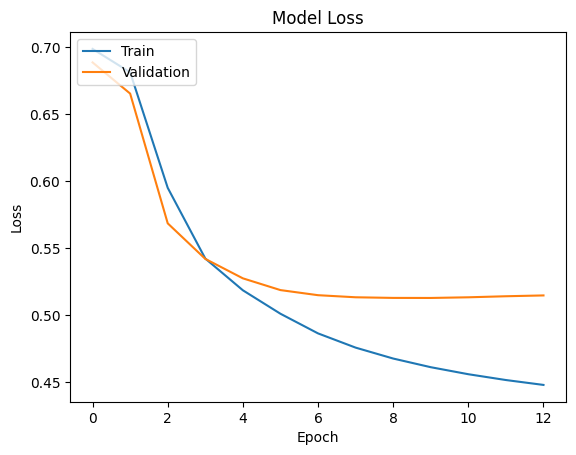

In [12]:
# Plot training results
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

## 9. 📌 Extracting Embedding Weights
🧠 Concepts Used:

Learned Embeddings: Vectors representing user/item preferences.

Normalization: Ensures fair similarity comparisons using cosine distance.



In [13]:
# Extract weights
def extract_weights(name, model):
    weights = model.get_layer(name).get_weights()[0]
    return weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [15]:
import pickle

# Save encoders
with open("user_encoder.pkl", "wb") as f:
    pickle.dump(user2user_encoded, f)

with open("anime_encoder.pkl", "wb") as f:
    pickle.dump(anime2anime_encoded, f)

## 10. 📑 Loading Anime Metadata
🧠 Concepts Used:

Metadata Joining: Brings additional descriptive info (e.g. English name, synopsis) to enrich recommendations.



In [16]:

# Load anime metadata
anime_df = pd.read_csv(INPUT_DIR + '/anime.csv')
anime_df.rename(columns={'MAL_ID': 'anime_id', 'English name': 'eng_version'}, inplace=True)

# Get anime synopsis
sypnopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', usecols=["MAL_ID", "Name", "sypnopsis"])
sypnopsis_df.rename(columns={'MAL_ID': 'anime_id'}, inplace=True)

anime_df.head()

,anime_id,Name,Score,Genres,eng_version,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [17]:
sypnopsis_df.head()

,anime_id,Name,sypnopsis
0,1,Cowboy Bebop,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"other day, another bounty—such is the life of ..."
2,6,Trigun,"Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,ches are individuals with special powers like ...
4,8,Bouken Ou Beet,It is the dark century and the people are suff...


## 11. 💡 Recommendation Functions
🧠 Concepts Used:

Content-Based Filtering: find_similar_animes() finds similar anime based on embedding distance.

Neural Collaborative Filtering: get_recommendations() predicts unseen anime ratings for a given user.



In [18]:
# Functions for recommendations
def find_similar_animes(name, n=10):
    anime_id = anime_df[anime_df.eng_version == name].anime_id.values[0]
    encoded_id = anime2anime_encoded.get(anime_id)
    dists = np.dot(anime_weights, anime_weights[encoded_id])
    similar_ids = np.argsort(dists)[-n-1:][::-1]
    return anime_df[anime_df.anime_id.isin([anime_encoded2anime[x] for x in similar_ids])]

def get_recommendations(user_id, n=10):
    user_encoder = user2user_encoded[user_id]
    not_watched = list(set(anime_df.anime_id) - set(rating_df[rating_df.user_id == user_id].anime_id))
    predictions = model.predict([np.array([user_encoder] * len(not_watched)), np.array(not_watched)])
    top_indices = np.argsort(predictions.flatten())[-n:]
    return anime_df[anime_df.anime_id.isin([anime_encoded2anime[x] for x in top_indices])]

In [19]:
find_similar_animes('Dragon Ball')

,anime_id,Name,Score,Genres,eng_version,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
200,223,Dragon Ball,8.0,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",Dragon Ball,ドラゴンボール,TV,153,"Feb 26, 1986 to Apr 12, 1989",Winter 1986,...,88245.0,89656.0,134427.0,108758.0,39962.0,14806.0,3942.0,1392.0,834.0,1204.0
201,225,Dragon Ball GT,6.48,"Action, Sci-Fi, Adventure, Comedy, Super Power...",Dragon Ball GT,ドラゴンボールGT,TV,64,"Feb 7, 1996 to Nov 19, 1997",Winter 1996,...,22680.0,23836.0,44045.0,74704.0,67689.0,42801.0,26843.0,11272.0,5903.0,4003.0
264,288,Bakuten Shoot Beyblade,6.73,"Action, Sci-Fi, Adventure, Comedy, Sports, Sho...",Beyblade,爆転シュート ベイブレード,TV,51,"Jan 8, 2001 to Dec 24, 2001",Winter 2001,...,3532.0,4279.0,9037.0,15837.0,12165.0,7272.0,2574.0,1152.0,554.0,325.0
451,481,Yu☆Gi☆Oh! Duel Monsters,7.47,"Adventure, Game, Shounen",Yu-Gi-Oh!,遊☆戯☆王 デュエルモンスターズ,TV,224,"Apr 18, 2000 to Sep 29, 2004",Spring 2000,...,22043.0,23717.0,45706.0,53971.0,25785.0,11867.0,3596.0,1315.0,555.0,386.0
494,527,Pokemon,7.34,"Action, Adventure, Comedy, Kids, Fantasy",Pokémon,ポケットモンスター,TV,276,"Apr 1, 1997 to Nov 14, 2002",Spring 1997,...,34911.0,33357.0,64105.0,85456.0,46215.0,23633.0,6723.0,2616.0,1256.0,1146.0
515,550,Yu☆Gi☆Oh!,7.21,"Action, Game, Comedy, Fantasy, Shounen",Unknown,遊☆戯☆王,TV,27,"Apr 4, 1998 to Oct 10, 1998",Spring 1998,...,9533.0,11182.0,22703.0,32814.0,17335.0,8500.0,2705.0,1026.0,474.0,357.0
517,552,Digimon Adventure,7.79,"Action, Adventure, Comedy, Fantasy, Kids",Digimon:Digital Monsters,デジモンアドベンチャー,TV,54,"Mar 7, 1999 to Mar 26, 2000",Spring 1999,...,31514.0,34838.0,57073.0,53135.0,21819.0,9186.0,2219.0,782.0,381.0,348.0
734,813,Dragon Ball Z,8.16,"Action, Adventure, Comedy, Fantasy, Martial Ar...",Dragon Ball Z,ドラゴンボールZ,TV,291,"Apr 26, 1989 to Jan 31, 1996",Spring 1989,...,144729.0,128360.0,158845.0,115623.0,43658.0,18301.0,5619.0,2157.0,1143.0,1618.0
789,874,Digimon Tamers,7.62,"Adventure, Comedy, Drama, Fantasy, Shounen",Digimon Tamers,デジモンテイマーズ,TV,51,"Apr 1, 2001 to Mar 31, 2002",Spring 2001,...,11119.0,16541.0,28728.0,26107.0,11862.0,5260.0,1523.0,517.0,236.0,149.0
1193,1313,Digimon Adventure 02,7.24,"Action, Adventure, Comedy, Drama, Fantasy, Kids",Digimon Adventure 02,デジモンアドベンチャー０２,TV,50,"Apr 2, 2000 to Mar 25, 2001",Spring 2000,...,10012.0,14774.0,27810.0,37308.0,19726.0,9127.0,3131.0,990.0,436.0,228.0


In [20]:
get_recommendations(0)

547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,anime_id,Name,Score,Genres,eng_version,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
1485,1634,Ai Shimai: Futari no Kajitsu,6.5,Hentai,Immoral Sisters,愛姉妹～二人の果実～,OVA,3,"Apr 27, 2001 to Sep 21, 2001",Unknown,...,316.0,300.0,660.0,1013.0,860.0,635.0,238.0,117.0,75.0,82.0
1603,1764,Slam Dunk (Movie),7.36,"Comedy, Drama, School, Shounen, Slice of Life,...",Unknown,スラムダンク,Movie,1,"Mar 12, 1994",Unknown,...,756.0,845.0,1800.0,2402.0,1058.0,476.0,115.0,34.0,15.0,13.0
2442,2657,Doraemon Movie 08: Nobita to Ryuu no Kishi,7.0,"Adventure, Comedy, Fantasy, Kids, Shounen",Doraemon the Movie:Nobita and the Knights on D...,映画 ドラえもん のび太と竜の騎士,Movie,1,"Mar 14, 1987",Unknown,...,134.0,125.0,370.0,517.0,316.0,153.0,44.0,15.0,7.0,7.0
2548,2768,CLAMP in Wonderland 2,7.47,"Action, Fantasy, Magic, Comedy, Romance, Music...",Unknown,CLAMP IN WONDERLAND 2,Music,1,"Oct 26, 2007",Unknown,...,1440.0,1464.0,2380.0,2446.0,1404.0,737.0,205.0,105.0,61.0,33.0
8031,19193,Koukaku Kidoutai Arise: Ghost in the Shell - B...,7.37,"Sci-Fi, Police, Psychological, Mecha",Ghost in the Shell:Arise - Border 3:Ghost Tears,攻殻機動隊ARISE -GHOST IN THE SHELL- border:3 Ghost...,Movie,1,"Jun 28, 2014",Unknown,...,1038.0,2295.0,5243.0,5662.0,2110.0,883.0,368.0,117.0,68.0,60.0
11630,32947,Battery,5.72,"Slice of Life, Sports, Drama",Unknown,バッテリー,TV,11,"Jul 15, 2016 to Sep 23, 2016",Summer 2016,...,331.0,500.0,1536.0,3542.0,4534.0,3541.0,2264.0,1018.0,478.0,363.0
12265,34136,Orange: Mirai,7.44,"Sci-Fi, Drama, Romance, School, Shoujo",Unknown,orange －未来－,Movie,1,"Nov 18, 2016",Unknown,...,3486.0,4157.0,7754.0,8191.0,3629.0,1564.0,667.0,316.0,186.0,170.0
13663,36497,Overlord Movie: Ple Ple Pleiades,6.87,"Action, Comedy, Magic, Fantasy",Unknown,劇場版 オーバーロード ぷれぷれぷれあです,Special,2,"Sep 13, 2017",Unknown,...,479.0,351.0,848.0,1760.0,1307.0,530.0,140.0,71.0,45.0,39.0
16256,40610,Healin' Good♡Precure,6.88,"Action, Magic, Fantasy, Shoujo",Healin' Good Pretty Cure,ヒーリングっど♥プリキュア,TV,45,"Feb 2, 2020 to Feb 21, 2021",Winter 2020,...,125.0,109.0,236.0,401.0,232.0,133.0,61.0,32.0,12.0,21.0
17101,42774,Sayonara Watashi no Cramer,Unknown,"Sports, Drama, Shounen","Good-bye, Cramer",さよなら私のクラマー,TV,Unknown,"Apr 4, 2021 to ?",Spring 2021,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


## 12. 💾 Saving the Model
🧠 Concepts Used:

Model Persistence: Saving the trained model for future inference or deployment (e.g. via Streamlit).



In [22]:
# Save the model
model.save("anime_model.h5")

In [25]:
import zipfile

with zipfile.ZipFile("anime_model.zip", "w") as zipf:
    zipf.write("anime_model.h5")

In [26]:
import os
os.listdir('/kaggle/working')


['anime_model1.h5',
 'anime_model.h5',
 'user_encoder.pkl',
 'anime_encoder.pkl',
 'anime_model1.zip',
 '.virtual_documents',
 'anime_model.zip',
 '.weights.h5']

In [30]:
!pip install -q --upgrade gdown
import gdown
import shutil

# Copy file từ Kaggle vào thư mục tạm
shutil.copy('/kaggle/working/anime_model.zip', '/kaggle/working/anime_project_copy.zip')

'/kaggle/working/anime_project_copy.zip'